# Introduction

The Consumer Financial Protection Bureau (CFPB) was founded in 2011 in response to the 2008 housing crisis in order to monitor and evaluate the financial marketplace and address consumer concerns regarding the financial sector and its products. (Cite: www.consumerfinance.gov/about-us/the-bureau). A part of the CFPB's goal regarding transparency and response to consumer concerns, the bureau provides open access to regularly updated data for the complaints it receives. The task set forth in this project is to explore the CFPB consumer complaint database (and other publically available data sources) to discover patterns or trends that may be of interest for financial sector companies seeking to take a proactive approach to addressing perceived problems in products or practices. 

# Scope

For the purpose of this project, I have elected to concentrate analysis on the complaints received for the continental United States, leaving out (where applicable) considerations for Alaska, Hawaii, and US territories such as Puerto Rico and the Virgin Islands. I have also dropped consideration of the free-form text of the consumer narrative (where applicable), as these were few to begin with and exploration of that text would fall outside of the intended, more general scope of this project.

# Datasets

## Primary Sources

There are three primary sources used to provide data for analysis: The Consumer Finance Bureau Consumer Complaint Database, IRS Individual Income Tax Statistics, and demographic data provided by the US Census Bureau. Each of these datasets is available publically from the web sites of the respective government agencies. In order to help with data munging and preliminary exploration, each of these datasets was imported into a Postgre database, whereafter transformed data was exported into CSV format before clustering analysis. 

## Transformation and Reconciliation

Minor data transformations were performed on the CFPB dataset in order to facilitate alignment with the IRS income statistics and the Census Bureau demographics data. For example, the State column was transformed from state name ("Alabama") to state abbreviation ("AL"). Additionally, because the Census bureau data was aggregated on a county level and the CFPB data was aggregated by zip code, I used HUD USPS Zip Code Crosswalk data freely available from the US Department of Housing and Urban Development (www.huduser.gov/portal/datasets/usps_crosswalk.html) from  in order to translate zip codes into counties. Because counties do not always circumscribe zip codes, in the case that a zip code for an observation corresponded to multiple counties, one of these counties was chosen uniformly at random. This inevitably introduces some fine-grain inaccuracies regarding the representation of the data, but this seemed to be a reasonable solution given the lack of resolution provided between the data sets to more adequately translate the aggregations. Further, such a strategy is not expected to significantly impact the aggregated results of this project. Additionally, the Census Bureau population counts were transformed into percentages by dividing by the total county population to allow for smaller and larger counties with similar demographic profiles to be adequately compared.

## Shape and Features

A total of 462,939 observations are used. The merged dataset itself contains 93 attributes: 17 attributes are directly taken from the CFPB complaint dataset, 2 are attributes added to a code to help with identifying counties along with the county name, 1 is the county-level adjusted gross income calculated from the IRS dataset, and the 73 columns thereafter are county-level population demographics taken from the Census dataset. An enumeration and brief description of these column names is provided in the appendix. 

# Cluster Modeling

A k-means algorithm was used in order to extract clustering information from this dataset. The goal in using k-means on the merged CFPB data is to identify subpopulations of consumers that have made complaints to the CFPB on their behalf. This identification can serve as the basis of a targeted action plan by those in the financial sector seeking to proactively address consumer concerns in products, processes, or practices for their own consumer bases. These cluster groups may also be of interest to those seeking to understand how different consumers in different areas of the country perceive harms by the financial industry.

In order to input columns containing categorical data into k-means, one-hot encoding was used to transform these columns. This significantly increases the dimensionality of the data. However, these clustering algorithms make use of distance metrics that categorical data does not permit, so this transformation is necessary as a preliminary step. After that, the dimensionality of the data was reduced by using principal component analysis. This effectively linearly projects the data from its sparse, high-dimensional representation into a lower-dimensional space. This reduction of sparsity is meant to improve the quality of the clusters returned by k-means. Additionally, because k-means is sensitive to the parameter k, the number of clusters, an estimate of an optimal k was obtained by graphing the dispursion of the hypothetical clusters. k was chosen from this graph by selecting the value that reduces cluster dispursion while minimizing the total number of clusters introduced into the model.

A downside of any unsupervised clustering model is that the resultant clusters can be difficult to interpret, since they may or may not correspond to obvious relationships or existing categories. After producing the k-means model, we use the clustering results to train a Random Forest model in order to extract key factors explaining the clustering result.

# Clustering Results

## Determining k

<!-- ![Figure 1: Find k](findK.png) --> 
Pull out the new findk png!

Based on cluster dispursion, it appears that k=3 is an optimal value for this analysis, though 4 and 5 may also be acceptable in other cases.

## Visualizing the k-means clusters
<!-- ![Figure 2: 2D PCA Projection of Clusters](pca_projection_chosen.png) -->
Pull out the new k-means clustering visual!

Here we can see three clusters, two clearly defined and the third far to the right in a darker blue.

# Cluster Analysis via Further Modeling

Following the clustering result from k-means, a Random Forest model was trained using the same one-hot encoded data that was fed into k-means along with the clustering results. A Random Forest model was chosen for this due to its robust nature: it tends to not overfit data, has relatively few hyperparameters, and handles outliers reasonably. Further, the Random Forest model includes an intrinsic, robust measure of its performance, called the out-of-bag score, which removes the need for a separate training and test set along with separate cross validation of the trained model. That score was used to evaluate the appropriateness of the model after training. 

The Random Forest ensemble model was trained with 1000 estimators and yielded an out-of-bag score of 0.9998, where a score of 1.0 would be a perfect model. After training, the model yielded a list of the most important features used in its classification. Since the importance of the individual features trails off quickly and the total number of features is very high, the top 10 features were given particular attention in the following analysis.

# Conclusion

# Further Exploration

# Appendix: Column Names

| Tables        | Are           | Cool  |
| ------------- |:-------------:| -----:|
| col 3 is      | right-aligned | 1600 |
| col 2 is      | centered      |   12 |
| zebra stripes | are neat      |    1 |


In [1]:
#######################################################################################################################

In [2]:
#Introductory imports and helper function definitions

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [4]:
def makeHistogramCategorical(data, xlabel, ylabel, title, filename=None):
    import matplotlib.pyplot as plt
    from matplotlib import rcParams
    rcParams.update({'figure.autolayout': True})
    #data = rows.CompCat.value_counts()
    plt.figure(figsize=(8,8))
    plt.bar(range(len(data)), data.values, align='center')
    plt.xticks(range(len(data)), data.index.values, size='medium', rotation='vertical')
    #plt.ylabel('Complaint Counts', size='large')
    plt.ylabel(ylabel, size='large')
    #plt.xlabel('Product Type', size='large')
    plt.xlabel(xlabel, size='large')
    #plt.title('Figure 1: Complaint Breakdown by Product Type', size='large')
    plt.title(title, size='large')
    #plt.gcf().subplots_adjust(bottom=0.25)
    #plt.savefig("figure1.png", format='png')
    if filename is not None:
        plt.savefig(filename, format='png')
    plt.show()

In [5]:
# From Mike Bernico

def find_k (X, k_range, sample_percent=1):
    """
    k_range: a list of possible k values
    X, the data we're clustering on
    """
    from sklearn.cluster import KMeans
    import matplotlib.pyplot as plt
    import numpy as np
    from scipy.spatial.distance import cdist
    from sklearn.metrics import pairwise_distances

    N = X.shape[0]
    sampleSize = X.shape[0] * sample_percent

    if sampleSize > 0:
        index = np.arange(np.shape(X)[0])
        np.random.shuffle(index)
        X =  X[index, :]


    mean_distortions=[]
    for k in k_range:
        #cluster using k, then calculate the mean distortion (average distance to closest centroid)
        kmeans_model = KMeans(n_clusters=k, init='k-means++', n_jobs=-1).fit(X)
        mean_distortions.append(sum(np.min(pairwise_distances(X, kmeans_model.cluster_centers_,
                                                              metric='euclidean'),axis=1)) / X.shape[0])


    #visualize results
    plt.plot(k_range, mean_distortions)
    plt.xlabel("K Value")
    plt.ylabel("Mean Distortion")
    plt.title("Elbow Graph for Mean Distortion per K")
    plt.show()
    
#Use example:

#find_k(np.matrix(X), range(1,10),1)

In [6]:
cfpbData = pd.read_csv("mergedDataset.csv")

In [7]:
statePopulations = pd.read_csv("statePopulations-cleaned.csv")

In [8]:
countyPopulations = pd.read_csv("countyPopulations-cleaned.csv")

# Exploratory Data Analysis

## General

In [9]:
cfpbData.shape

(462935, 93)

In [10]:
cfpbData.head()

,date_received,product,sub_product,issue,sub_issue,company_response,company,state_name,zip_code,tags,...,hisp_black_aoc_male,hisp_black_aoc_female,hisp_nativeam_aoc_male,hisp_nativeam_aoc_female,hisp_asian_aoc_male,hisp_asian_aoc_female,hisp_pacific_aoc_male,hisp_pacific_aoc_female,not_hisp_pacific_alone_female,hisp_nativeam_alone_female
0,2016-04-08,Credit reporting,NaN,Incorrect information on credit report,Personal information,Company believes complaint caused principally ...,"Credit Karma, Inc.",GA,30052.0,Neither,...,0.001277,0.001433,0.000836,0.000645,0.000191,0.000275,0.000155,0.000215,0.000263,0.00031
1,2016-03-25,Debt collection,Credit card,False statements or representation,Impersonated an attorney or official,NaN,"Portfolio Recovery Associates, Inc.",GA,30012.0,Neither,...,0.001277,0.001433,0.000836,0.000645,0.000191,0.000275,0.000155,0.000215,0.000263,0.00031
2,2016-03-24,Credit reporting,NaN,Credit monitoring or identity protection,Problem with fraud alerts,NaN,"TransUnion Intermediate Holdings, Inc.",GA,30014.0,Neither,...,0.001277,0.001433,0.000836,0.000645,0.000191,0.000275,0.000155,0.000215,0.000263,0.00031
3,2016-03-04,Debt collection,Credit card,Cont'd attempts collect debt not owed,Debt is not mine,NaN,Encore Capital Group,GA,30054.0,Neither,...,0.001277,0.001433,0.000836,0.000645,0.000191,0.000275,0.000155,0.000215,0.000263,0.00031
4,2016-03-04,Debt collection,Credit card,Cont'd attempts collect debt not owed,Debt is not mine,NaN,Encore Capital Group,GA,30054.0,Neither,...,0.001277,0.001433,0.000836,0.000645,0.000191,0.000275,0.000155,0.000215,0.000263,0.00031


### Complaint Breakdown by Major Product Type

In [11]:
cfpbData['product'].value_counts()

Mortgage                   164435
Debt collection             78516
Credit reporting            73565
Credit card                 55869
Bank account or service     53896
Consumer Loan               16079
Student loan                13038
Payday loan                  2899
Money transfers              2808
Prepaid card                 1449
Other financial service       381
Name: product, dtype: int64

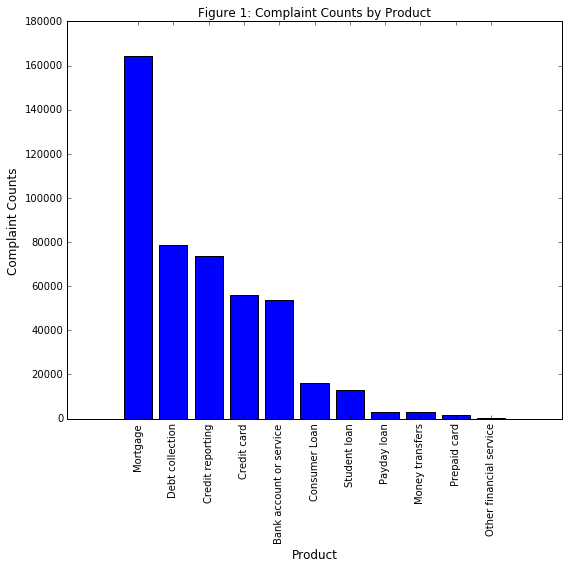

In [12]:
makeHistogramCategorical(cfpbData['product'].value_counts(), 
                         "Product", 
                         "Complaint Counts", 
                         "Figure 1: Complaint Counts by Product",
                        )

### Top 20 Complaint Issues

In [13]:
cfpbData['issue'].value_counts()[0:20]

Loan modification,collection,foreclosure    88370
Incorrect information on credit report      54392
Loan servicing, payments, escrow account    51459
Cont'd attempts collect debt not owed       32679
Account opening, closing, or management     23027
Deposits and withdrawals                    15005
Communication tactics                       14620
Disclosure verification of debt             14429
Application, originator, mortgage broker    11171
Other                                        9537
Billing disputes                             9353
Credit reporting company's investigation     7852
Problems caused by my funds being low        7810
Managing the loan or lease                   7707
Unable to get credit report/credit score     6397
False statements or representation           6224
Improper contact or sharing of info          5758
Settlement process and costs                 5598
Problems when you are unable to pay          5516
Identity theft / Fraud / Embezzlement        4883


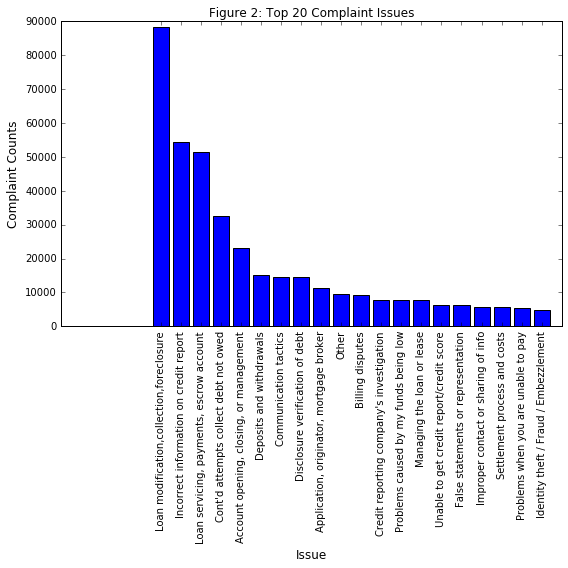

In [14]:
makeHistogramCategorical(cfpbData['issue'].value_counts()[0:20], 
                         "Issue", 
                         "Complaint Counts", 
                         "Figure 2: Top 20 Complaint Issues",
                        )

### Overall Adjusted Gross Income for Complaints

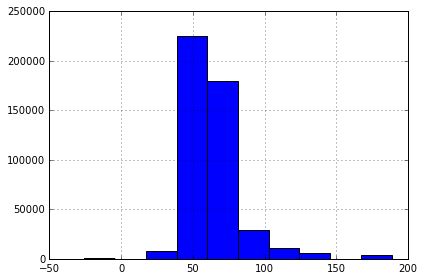

In [15]:
cfpbData.CountyAGI.hist()

### Top 20 States by Complaint Count

In [16]:
cfpbData['state_name'].value_counts()[0:20]

CA    69004
FL    45749
TX    34268
NY    33225
GA    20606
NJ    19332
PA    16960
IL    16511
VA    15267
MD    15071
OH    14710
NC    12779
MI    12520
AZ    10215
WA     9604
MA     9377
CO     8016
TN     6969
MO     6094
SC     5799
Name: state_name, dtype: int64

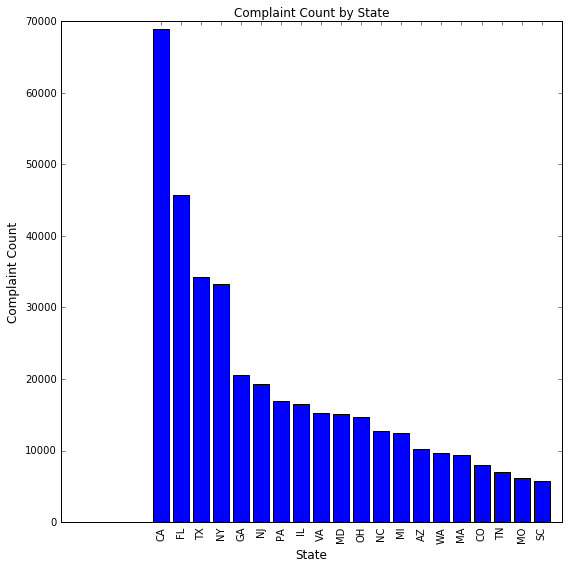

In [17]:
makeHistogramCategorical(cfpbData['state_name'].value_counts()[0:20], "State", "Complaint Count", "Complaint Count by State")

### Top 30 Counties for CFPB Complaints

In [18]:
cfpbData['county_name'].value_counts()[0:30]

Los Angeles County        19358
Orange County             10292
Cook County                8789
Maricopa County            6975
Broward County             6666
Miami-Dade County          6625
San Diego County           6590
Montgomery County          6121
Harris County              6004
Clark County               5225
Kings County               4722
Queens County              4545
Tarrant County             4495
Riverside County           4483
Dallas County              4387
Suffolk County             4232
Middlesex County           4200
New York County            4173
Palm Beach County          4087
Prince George's County     3836
San Bernardino County      3651
Jefferson County           3584
Hillsborough County        3398
Alameda County             3303
King County                3279
Fulton County              3151
Oakland County             3125
Nassau County              3100
Wayne County               3064
Sacramento County          3048
Name: county_name, dtype: int64

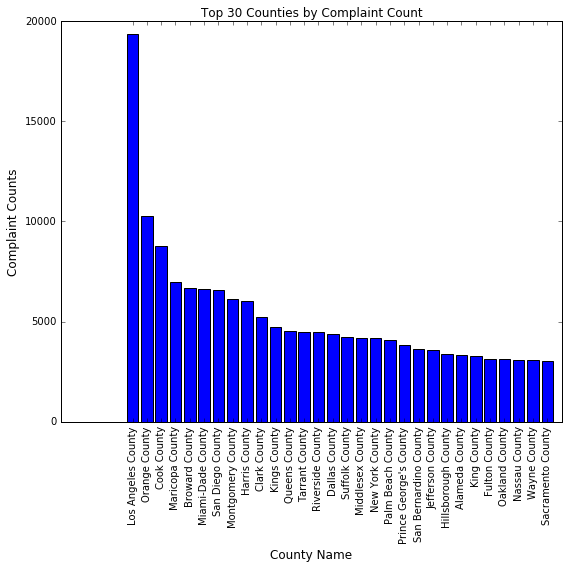

In [19]:
makeHistogramCategorical(cfpbData['county_name'].value_counts()[0:30], "County Name", "Complaint Counts", "Top 30 Counties by Complaint Count")

### Complaint Breakdown by Company (Top 20)

In [20]:
cfpbData['company'].value_counts()[0:20]

Bank of America                           50888
Wells Fargo & Company                     37443
JPMorgan Chase & Co.                      29810
Experian                                  25225
Equifax                                   25184
Citibank                                  21827
TransUnion Intermediate Holdings, Inc.    20246
Ocwen                                     18612
Capital One                               13447
Nationstar Mortgage                       11209
U.S. Bancorp                               8193
Synchrony Financial                        7691
Ditech Financial LLC                       7239
Navient Solutions, Inc.                    6610
PNC Bank N.A.                              6199
HSBC North America Holdings Inc.           5525
Encore Capital Group                       5147
Amex                                       4710
SunTrust Banks, Inc.                       4277
Discover                                   3958
Name: company, dtype: int64

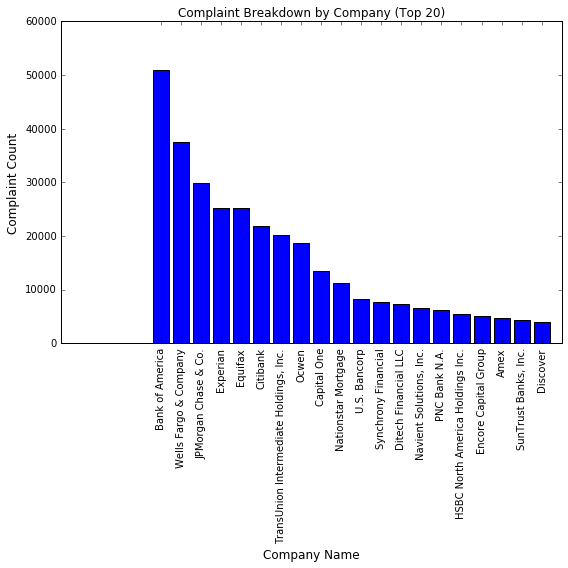

In [21]:
makeHistogramCategorical(cfpbData['company'].value_counts()[0:20], "Company Name", "Complaint Count", "Complaint Breakdown by Company (Top 20)")

### Customer Dispute Counts

In [22]:
cfpbData['consumer_disputed'].value_counts()

No     371119
Yes     91816
Name: consumer_disputed, dtype: int64

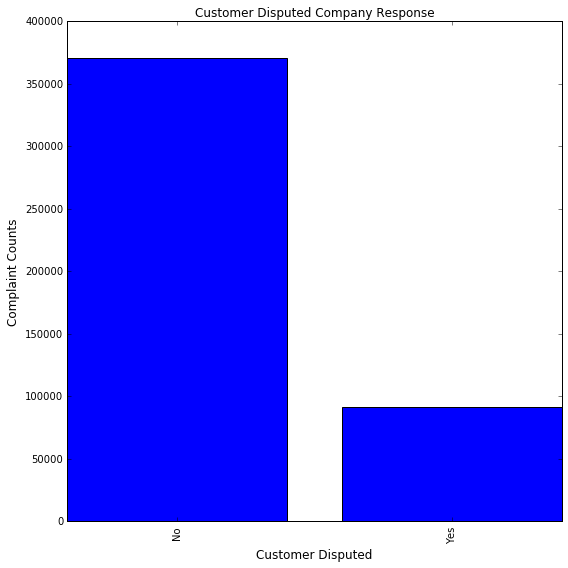

In [23]:
makeHistogramCategorical(cfpbData['consumer_disputed'].value_counts(), "Customer Disputed", "Complaint Counts", "Customer Disputed Company Response")

## Mortgage

### Mortgage Issue Complaint Counts and Breakdown

In [24]:
cfpbData.query("""product=='Mortgage'""")['issue'].value_counts()

Loan modification,collection,foreclosure    88370
Loan servicing, payments, escrow account    51459
Application, originator, mortgage broker    11171
Settlement process and costs                 5598
Other                                        4154
Credit decision / Underwriting               3683
Name: issue, dtype: int64

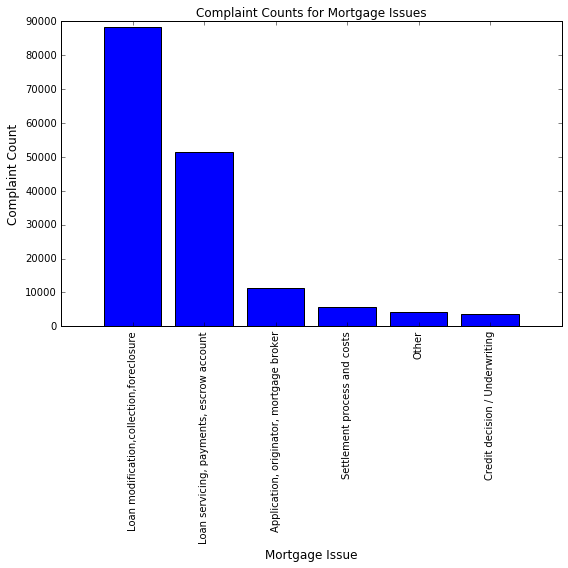

In [25]:
makeHistogramCategorical(cfpbData.query("""product=='Mortgage'""")['issue'].value_counts(), "Mortgage Issue", "Complaint Count", "Complaint Counts for Mortgage Issues")

### Mortgage Complaints by County (Top 30)

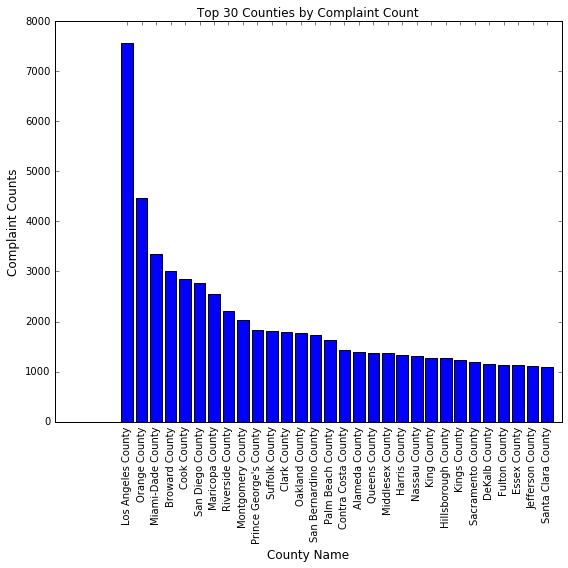

In [26]:
makeHistogramCategorical(cfpbData.query("""product=='Mortgage'""")['county_name'].value_counts()[0:30], "County Name", "Complaint Counts", "Top 30 Counties by Complaint Count")

### Top 20 States for Mortgage-related Complaints

In [27]:
cfpbData.query('product=="Mortgage"')['state_name'].value_counts()[0:20]

CA    29394
FL    18555
NY    10391
GA     8454
TX     7708
NJ     7617
MD     6367
IL     5471
PA     5323
MI     5300
VA     5084
NC     4873
OH     4709
AZ     3815
WA     3751
MA     3246
CO     2860
MO     2086
MN     2076
TN     2035
Name: state_name, dtype: int64

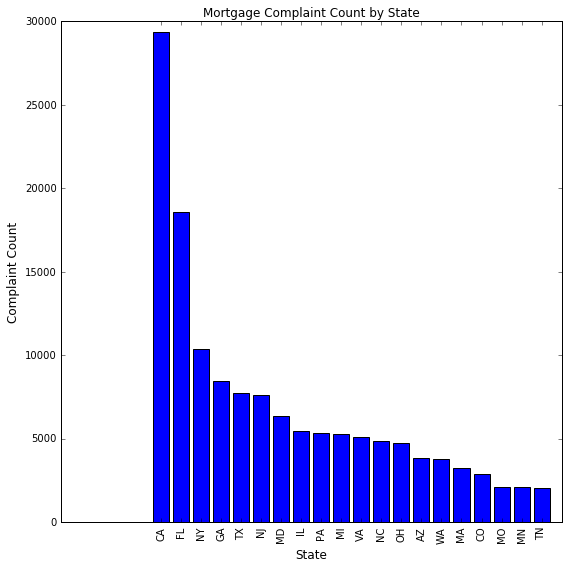

In [28]:
makeHistogramCategorical(cfpbData.query('product=="Mortgage"')['state_name'].value_counts()[0:20], "State", "Complaint Count", "Mortgage Complaint Count by State")

Interesting note: A good number of these states have either judicial foreclosure proceedings or enhanced legislation regarding foreclosure procedures. For example, California has a Homeowner Bill of Rights (http://oag.ca.gov/hbor); Florida, New York, New Jersey, Maryland, Illinois, Pennsylvania, Ohio, and Massachusetts all have judicial-only foreclosure processes, as opposed to non-judicial foreclosure procedings made in other states (http://www.nolo.com/legal-encyclopedia/chart-judicial-v-nonjudicial-foreclosures.html, http://www.realtytrac.com/real-estate-guides/foreclosure-laws/).

### Top 20 States by Judicial or Enhanced vs Non-Judicial Foreclosure [Mortgage]

In [29]:
top20counts = cfpbData.query('product=="Mortgage"')['state_name'].value_counts()[0:20]
top20counts

CA    29394
FL    18555
NY    10391
GA     8454
TX     7708
NJ     7617
MD     6367
IL     5471
PA     5323
MI     5300
VA     5084
NC     4873
OH     4709
AZ     3815
WA     3751
MA     3246
CO     2860
MO     2086
MN     2076
TN     2035
Name: state_name, dtype: int64

In [30]:
### For the purpose of this calculation, California will be included in the Judical figure
### due to its enhanced foreclosure legislation
top20counts = cfpbData.query('product=="Mortgage"')['state_name'].value_counts()[0:20]
sumJudicial = 0

for state in ['CA', 'FL', 'NY', 'NJ', 'MD', 'IL', 'PA', 'OH', 'MA']:
    sumJudicial+=top20counts[state]

totalTop20Counts = 0
for v in top20counts:
    totalTop20Counts+=v

from __future__ import division
print "From the top 20 states by complaint count"
print "Judicial or Enhanced: \t", sumJudicial, " = ", sumJudicial/totalTop20Counts,"%"
print "Non-judicial: \t\t", totalTop20Counts-sumJudicial, " = ", (totalTop20Counts-sumJudicial)/totalTop20Counts,"%"

From the top 20 states by complaint count
Judicial or Enhanced: 	91073  =  0.654659813823 %
Non-judicial: 		48042  =  0.345340186177 %


### AGI for Mortgage Complaints

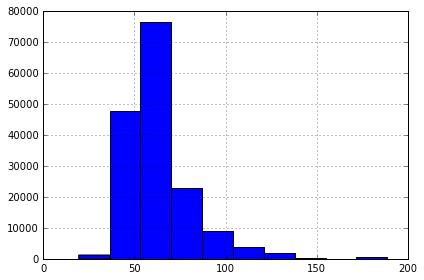

In [31]:
cfpbData.query("""product == 'Mortgage'""").CountyAGI.hist()

## Debt Collection

### Debt Collection Issue Complaint Counts and Breakdown

In [32]:
cfpbData.query("""product=='Debt collection'""")['issue'].value_counts()

Cont'd attempts collect debt not owed    32679
Communication tactics                    14620
Disclosure verification of debt          14429
False statements or representation        6224
Improper contact or sharing of info       5758
Taking/threatening an illegal action      4806
Name: issue, dtype: int64

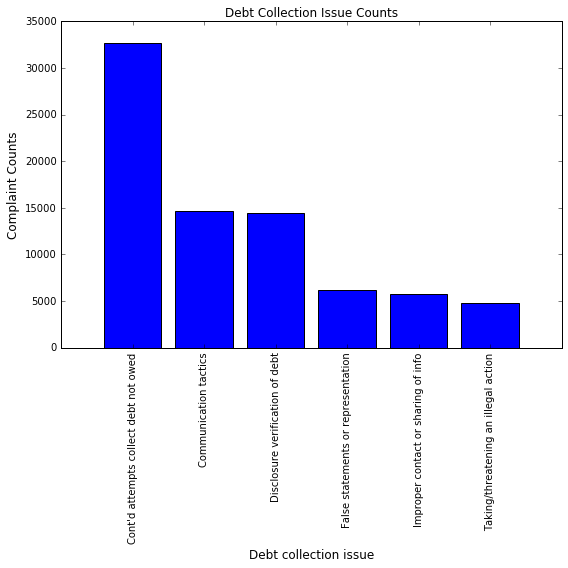

In [33]:
makeHistogramCategorical(cfpbData.query("""product=='Debt collection'""")['issue'].value_counts(), "Debt collection issue", "Complaint Counts", "Debt Collection Issue Counts")

### AGI for Debt Collection Complaints

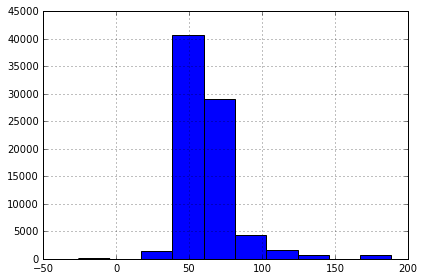

In [34]:
cfpbData.query("""product == 'Debt collection'""").CountyAGI.hist()

## Credit Reporting

### AGI for Credit Reporting

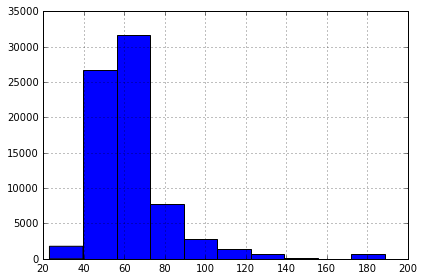

In [35]:
cfpbData.query("""product == 'Credit reporting'""").CountyAGI.hist()

## Bank Account

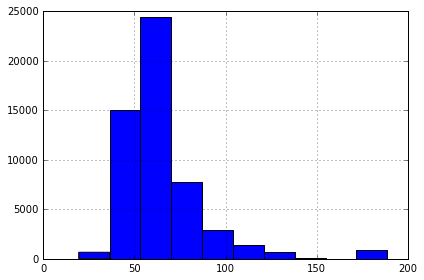

In [36]:
cfpbData.query("""product == 'Bank account or service'""").CountyAGI.hist()

## Consumer Loan

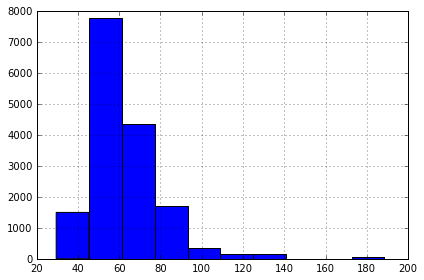

In [37]:
cfpbData.query("""product == 'Consumer Loan'""").CountyAGI.hist()

## Student Loan

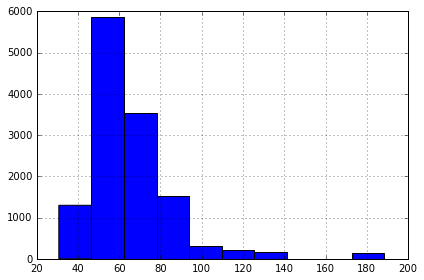

In [38]:
cfpbData.query("""product == 'Student loan'""").CountyAGI.hist()

## Payday Loan

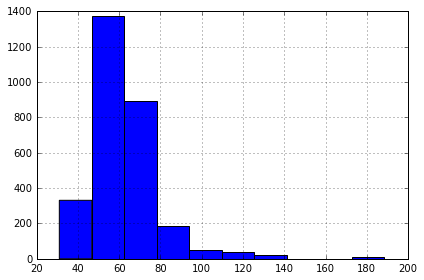

In [39]:
cfpbData.query("""product == 'Payday loan'""").CountyAGI.hist()

## Money Transfers

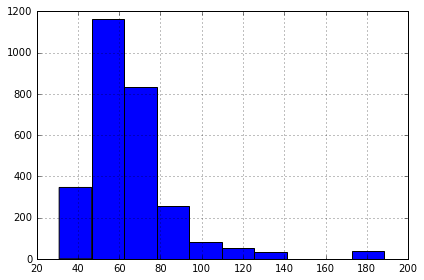

In [40]:
cfpbData.query("""product == 'Money transfers'""").CountyAGI.hist()

## Prepaid Card

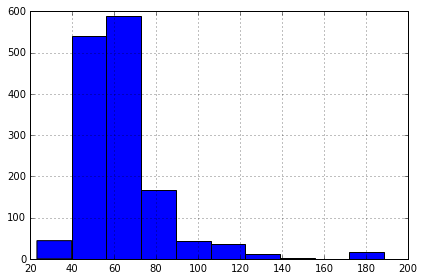

In [41]:
cfpbData.query("""product == 'Prepaid card'""").CountyAGI.hist()

## Other Financial Service

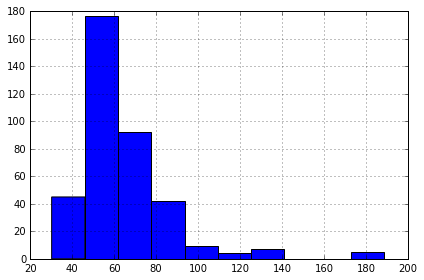

In [42]:
cfpbData.query("""product == 'Other financial service'""").CountyAGI.hist() 

# Modeling and Inferences

First, relevant attributes are chosen from the dataset. Then, the categorical features are encoded with one-hot encoding in order to be amenable to a k-means algorithm. Then, an optimal clustering number, k, is determined by measuring potential clustering dispersion with k from 1 to 10. Following that, the data is clustered using a k-means algorithm.

In [43]:
# Consider transformation into one-hot encoding and using a KMeans clustering algorithm

In [44]:
#X = pd.DataFrame()
#X['product']=cfpbData['product']
#X['state_name']=cfpbData['state_name']
#X['tags']=cfpbData['tags']
#X['company']=cfpbData['company']
#X['timely_response']=cfpbData['timely_response']
#X['consumer_disputed']=cfpbData['consumer_disputed']
#X['CountyAGI']=cfpbData['CountyAGI']
#X.columns

In [45]:
X = cfpbData

In [46]:
del X['date_received']

In [47]:
del X['company_response']

In [48]:
del X['consumer_consent_provided']

In [49]:
del X['submitted_via']

In [50]:
del X['complaint_id']

In [51]:
del X['county_code']

In [52]:
del X['zip_code']

In [53]:
del X['date_sent']

In [54]:
del X['company_response_status']

In [55]:
del X['county_name']

In [56]:
X.columns

Index([u'product', u'sub_product', u'issue', u'sub_issue', u'company',
       u'state_name', u'tags', u'timely_response', u'consumer_disputed',
       u'CountyAGI', u'total_pop', u'total_male_pop', u'total_female_pop',
       u'white_alone_male_pop', u'white_female_alone_pop', u'black_alone_male',
       u'black_alone_female', u'nativeam_male_alone', u'nativeam_female_alone',
       u'asian_male_alone', u'asian_female_alone', u'pacific_male_alone',
       u'pacific_female_alone', u'mixed_male_total', u'mixed_female_total',
       u'white_aoc_male', u'white_aoc_female', u'black_aoc_male',
       u'black_aoc_female', u'nativeam_aoc_male', u'nativeam_aoc_female',
       u'asian_aoc_male', u'asian_aoc_female', u'pacific_aoc_male',
       u'pacific_aoc_female', u'not_hisp_male_total', u'not_hisp_female_total',
       u'not_hisp_white_alone_male', u'not_hisp_white_alone_female',
       u'not_hisp_black_alone_male', u'not_hisp_black_alone_female',
       u'not_hisp_nativeam_alone_male', u'not

In [57]:
Xprime = X
del X

In [58]:
Xprime = pd.concat([Xprime, pd.get_dummies(Xprime['product'], prefix="product_")], axis=1)
del Xprime['product']

In [59]:
Xprime = pd.concat([Xprime, pd.get_dummies(Xprime['sub_product'], prefix="sub_product_")], axis=1)
del Xprime['sub_product']

In [60]:
Xprime = pd.concat([Xprime, pd.get_dummies(Xprime['issue'], prefix="issue_")], axis=1)
del Xprime['issue']

In [61]:
Xprime = pd.concat([Xprime, pd.get_dummies(Xprime['sub_issue'], prefix="sub_issue_")], axis=1)
del Xprime['sub_issue']

In [62]:
top20complaintCompany = cfpbData['company'].value_counts()[0:20]

def top20Company(x):
    if x in top20complaintCompany:
        return x
    else:
        return "OtherCompany"
    
Xprime['company']=map(top20Company, Xprime['company'])

Xprime = pd.concat([Xprime, pd.get_dummies(Xprime['company'], prefix="company_")], axis=1)
del Xprime['company']

In [63]:
Xprime = pd.concat([Xprime, pd.get_dummies(Xprime['state_name'], prefix="state_name_")], axis=1)
del Xprime['state_name']

In [64]:
Xprime = pd.concat([Xprime, pd.get_dummies(Xprime['tags'], prefix="tags_")], axis=1)
del Xprime['tags']

In [65]:
Xprime = pd.concat([Xprime, pd.get_dummies(Xprime['timely_response'], prefix='timely_response_')], axis=1)
del Xprime['timely_response']

In [66]:
Xprime = pd.concat([Xprime, pd.get_dummies(Xprime['consumer_disputed'], prefix='consumer_disputed_')], axis=1)
del Xprime['consumer_disputed']

In [67]:
Xprime.head()

,CountyAGI,total_pop,total_male_pop,total_female_pop,white_alone_male_pop,white_female_alone_pop,black_alone_male,black_alone_female,nativeam_male_alone,nativeam_female_alone,...,state_name__WV,state_name__WY,tags__Both,tags__Neither,tags__OlderAmerican,tags__Servicemember,timely_response__No,timely_response__Yes,consumer_disputed__No,consumer_disputed__Yes
0,57.830967,83768,0.513382,0.486618,0.399281,0.413523,0.072868,0.084973,0.001659,0.001624,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0
1,57.830967,83768,0.513382,0.486618,0.399281,0.413523,0.072868,0.084973,0.001659,0.001624,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0
2,57.830967,83768,0.513382,0.486618,0.399281,0.413523,0.072868,0.084973,0.001659,0.001624,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0
3,57.830967,83768,0.513382,0.486618,0.399281,0.413523,0.072868,0.084973,0.001659,0.001624,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0
4,57.830967,83768,0.513382,0.486618,0.399281,0.413523,0.072868,0.084973,0.001659,0.001624,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0


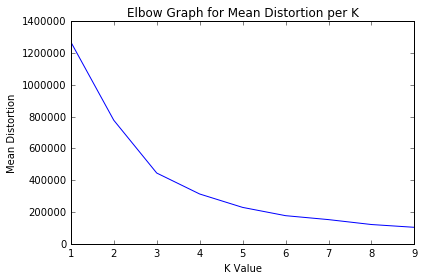

In [68]:
find_k(np.matrix(Xprime), range(1,10),1)

In [69]:
#Feature Scaling 

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
Xprime_scaled = scaler.fit_transform(Xprime)

In [70]:
#Preliminary feature selection via PCA
from sklearn.decomposition import PCA

Xprime_selected = PCA(n_components = 5).fit_transform(Xprime_scaled) #Trying 5 just because...


In [71]:
#Use k-means clustering

from sklearn.cluster import KMeans
# 3 clusters based on previous findk results.
kmeans_model = KMeans(n_clusters=3, random_state=42) 
kmeans_model.fit(Xprime_selected)

KMeans(copy_x=True, init='k-means++', max_iter=300, n_clusters=3, n_init=10,
    n_jobs=1, precompute_distances='auto', random_state=42, tol=0.0001,
    verbose=0)

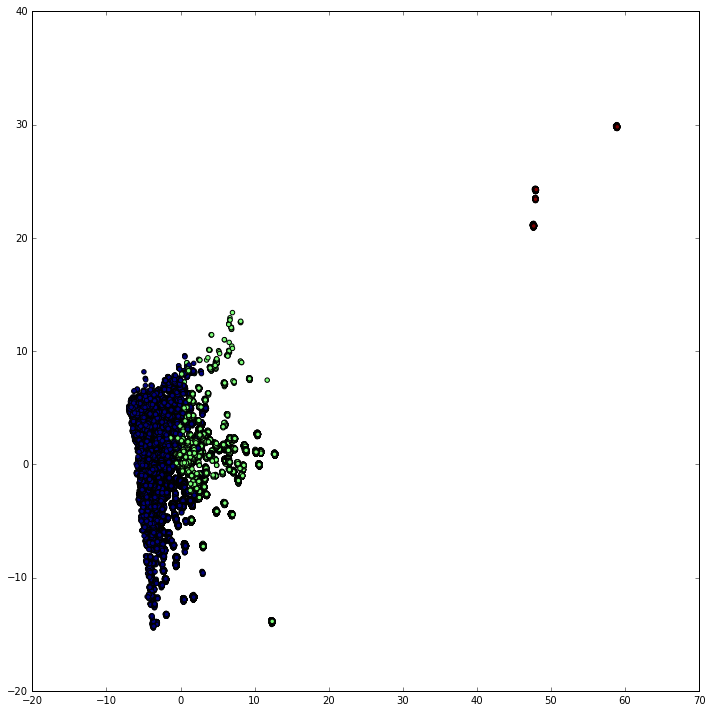

In [72]:
#Use PCA again merely for visualization purposes. These results are not used in the analysis.

from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

%matplotlib inline 
model = PCA(n_components=2)
X_pca = model.fit_transform(Xprime_selected) 
plt.figure(figsize=(10,10))
ax = plt.subplot(111)
ax.scatter(X_pca[:, 0], X_pca[:, 1], c= kmeans_model.labels_)

Blue = 0, Green = 1, and Brown/Red = 2

In [73]:
Xprime['labels'] = kmeans_model.labels_

In [75]:
#Save this version as it's already ready for inclusion into the Random Forest
Xprime.to_csv("clusteredDataset.csv", index=False) 

In [76]:
##############################################################################################
del Xprime

In [77]:
#Load clustered dataset 
clusteredData = pd.read_csv("clusteredDataset.csv")

In [78]:
clusteredData.head()

,CountyAGI,total_pop,total_male_pop,total_female_pop,white_alone_male_pop,white_female_alone_pop,black_alone_male,black_alone_female,nativeam_male_alone,nativeam_female_alone,...,state_name__WY,tags__Both,tags__Neither,tags__OlderAmerican,tags__Servicemember,timely_response__No,timely_response__Yes,consumer_disputed__No,consumer_disputed__Yes,labels
0,57.830967,83768,0.513382,0.486618,0.399281,0.413523,0.072868,0.084973,0.001659,0.001624,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0
1,57.830967,83768,0.513382,0.486618,0.399281,0.413523,0.072868,0.084973,0.001659,0.001624,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0
2,57.830967,83768,0.513382,0.486618,0.399281,0.413523,0.072868,0.084973,0.001659,0.001624,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0
3,57.830967,83768,0.513382,0.486618,0.399281,0.413523,0.072868,0.084973,0.001659,0.001624,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0
4,57.830967,83768,0.513382,0.486618,0.399281,0.413523,0.072868,0.084973,0.001659,0.001624,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0


# Analyzing the Clusters

## Complaint Count by Cluster

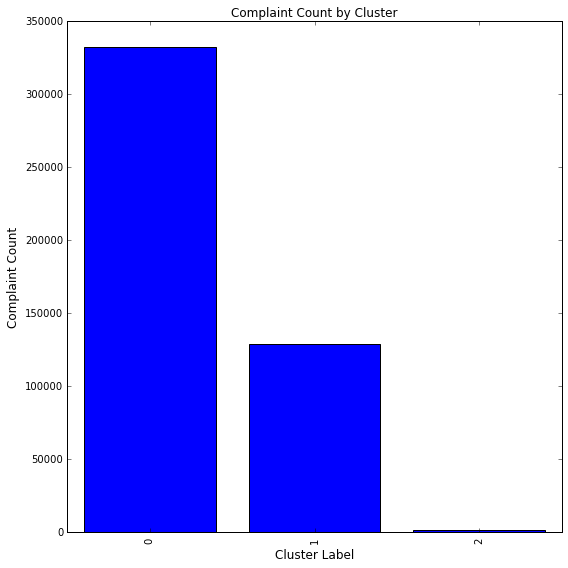

In [79]:
makeHistogramCategorical(clusteredData['labels'].value_counts(), "Cluster Label", "Complaint Count", "Complaint Count by Cluster")

Based on this, it appears that cluster label 2 is an outlier class.

In order to determine which variables are most relevant for the classification into each cluster, a Random Forest model is trained to match the k-means clustering results. Then, once the Random Forest model is trained, the model is interrogated with regard to the variables most relevant to clustering.

In [80]:
X = clusteredData
y = X.pop('labels')

In [81]:
X.head()

,CountyAGI,total_pop,total_male_pop,total_female_pop,white_alone_male_pop,white_female_alone_pop,black_alone_male,black_alone_female,nativeam_male_alone,nativeam_female_alone,...,state_name__WV,state_name__WY,tags__Both,tags__Neither,tags__OlderAmerican,tags__Servicemember,timely_response__No,timely_response__Yes,consumer_disputed__No,consumer_disputed__Yes
0,57.830967,83768,0.513382,0.486618,0.399281,0.413523,0.072868,0.084973,0.001659,0.001624,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0
1,57.830967,83768,0.513382,0.486618,0.399281,0.413523,0.072868,0.084973,0.001659,0.001624,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0
2,57.830967,83768,0.513382,0.486618,0.399281,0.413523,0.072868,0.084973,0.001659,0.001624,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0
3,57.830967,83768,0.513382,0.486618,0.399281,0.413523,0.072868,0.084973,0.001659,0.001624,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0
4,57.830967,83768,0.513382,0.486618,0.399281,0.413523,0.072868,0.084973,0.001659,0.001624,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0


In [82]:
y[0:5]

0    0
1    0
2    0
3    0
4    0
Name: labels, dtype: int64

In [88]:
from sklearn.ensemble import RandomForestClassifier
rfModel = RandomForestClassifier(n_estimators = 100, n_jobs=-1, oob_score=True)

In [89]:
rfModel.fit(X, y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
            oob_score=True, random_state=None, verbose=0, warm_start=False)

In [90]:
rfModel.oob_score_

0.99983583008413712

In [121]:
#Let's look at some top features used in our Random Forest model to help distinguish between
#the three clusters

importances = rfModel.feature_importances_
std = np.std([tree.feature_importances_ for tree in rfModel.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1][0:10]

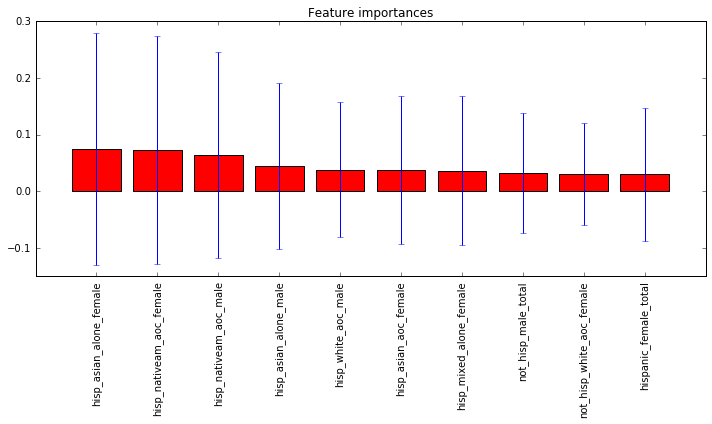

In [122]:
plt.figure(figsize=(10,6))
plt.title("Feature importances")
plt.bar(range(len(indices)), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(len(indices)), X.columns[indices], rotation=90)
plt.xlim([-1, len(indices)])
plt.show()

From the graph of the most important features used by the Random Forest model, we can see that each of the individual features used by the model have relatively low importance and very high uncertainty. However, looking at these features, it's worthwhile to note a few points: First, all of these features are demographic features that were not part of the CFPB dataset but were introduced from the US Census Bureau dataset. Secondly, most of these features involve a self-identified hispanic, hispanic multiracial, or mixed hispanic county-level demographic, with only two of the ten being non-hispanic demographics. Let us see how the model tended to cluster these groups.

In [132]:
clusteredData.head()

,CountyAGI,total_pop,total_male_pop,total_female_pop,white_alone_male_pop,white_female_alone_pop,black_alone_male,black_alone_female,nativeam_male_alone,nativeam_female_alone,...,state_name__WV,state_name__WY,tags__Both,tags__Neither,tags__OlderAmerican,tags__Servicemember,timely_response__No,timely_response__Yes,consumer_disputed__No,consumer_disputed__Yes
0,57.830967,83768,0.513382,0.486618,0.399281,0.413523,0.072868,0.084973,0.001659,0.001624,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0
1,57.830967,83768,0.513382,0.486618,0.399281,0.413523,0.072868,0.084973,0.001659,0.001624,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0
2,57.830967,83768,0.513382,0.486618,0.399281,0.413523,0.072868,0.084973,0.001659,0.001624,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0
3,57.830967,83768,0.513382,0.486618,0.399281,0.413523,0.072868,0.084973,0.001659,0.001624,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0
4,57.830967,83768,0.513382,0.486618,0.399281,0.413523,0.072868,0.084973,0.001659,0.001624,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0


In [133]:
mergedDataset = pd.read_csv("mergedDataset.csv")
mergedDataset['labels'] = y

In [134]:
mergedDataset.head()

,date_received,product,sub_product,issue,sub_issue,company_response,company,state_name,zip_code,tags,...,hisp_black_aoc_female,hisp_nativeam_aoc_male,hisp_nativeam_aoc_female,hisp_asian_aoc_male,hisp_asian_aoc_female,hisp_pacific_aoc_male,hisp_pacific_aoc_female,not_hisp_pacific_alone_female,hisp_nativeam_alone_female,labels
0,2016-04-08,Credit reporting,NaN,Incorrect information on credit report,Personal information,Company believes complaint caused principally ...,"Credit Karma, Inc.",GA,30052.0,Neither,...,0.001433,0.000836,0.000645,0.000191,0.000275,0.000155,0.000215,0.000263,0.00031,0
1,2016-03-25,Debt collection,Credit card,False statements or representation,Impersonated an attorney or official,NaN,"Portfolio Recovery Associates, Inc.",GA,30012.0,Neither,...,0.001433,0.000836,0.000645,0.000191,0.000275,0.000155,0.000215,0.000263,0.00031,0
2,2016-03-24,Credit reporting,NaN,Credit monitoring or identity protection,Problem with fraud alerts,NaN,"TransUnion Intermediate Holdings, Inc.",GA,30014.0,Neither,...,0.001433,0.000836,0.000645,0.000191,0.000275,0.000155,0.000215,0.000263,0.00031,0
3,2016-03-04,Debt collection,Credit card,Cont'd attempts collect debt not owed,Debt is not mine,NaN,Encore Capital Group,GA,30054.0,Neither,...,0.001433,0.000836,0.000645,0.000191,0.000275,0.000155,0.000215,0.000263,0.00031,0
4,2016-03-04,Debt collection,Credit card,Cont'd attempts collect debt not owed,Debt is not mine,NaN,Encore Capital Group,GA,30054.0,Neither,...,0.001433,0.000836,0.000645,0.000191,0.000275,0.000155,0.000215,0.000263,0.00031,0


In [144]:
(mergedDataset.query("""labels==0""")['hisp_asian_alone_female'].mean(),
 mergedDataset.query("""labels==1""")['hisp_asian_alone_female'].mean())

(0.000423595237060243, 0.002193308261492692)

In [145]:
(mergedDataset.query("""labels==0""")['hisp_nativeam_aoc_female'].mean(),
 mergedDataset.query("""labels==1""")['hisp_nativeam_aoc_female'].mean())

(0.0020776312208056168, 0.007215892494361203)

In [146]:
(mergedDataset.query("""labels==0""")['hisp_nativeam_aoc_male'].mean(),
 mergedDataset.query("""labels==1""")['hisp_nativeam_aoc_male'].mean())

(0.002312719910802029, 0.007526149032218437)

In [147]:
(mergedDataset.query("""labels==0""")['hisp_asian_alone_male'].mean(),
 mergedDataset.query("""labels==1""")['hisp_asian_alone_male'].mean())

(0.0004325625329237277, 0.002142435427032182)

In [148]:
(mergedDataset.query("""labels==0""")['hisp_white_aoc_male'].mean(),
 mergedDataset.query("""labels==1""")['hisp_white_aoc_male'].mean())

(0.04786420075582912, 0.17415252155733882)

In [149]:
(mergedDataset.query("""labels==0""")['hisp_asian_aoc_female'].mean(),
 mergedDataset.query("""labels==1""")['hisp_asian_aoc_female'].mean())

(0.0007691231017846226, 0.0036182140314220497)

In [151]:
(mergedDataset.query("""labels==0""")['hisp_mixed_alone_female'].mean(),
 mergedDataset.query("""labels==1""")['hisp_mixed_alone_female'].mean())

(0.0016473071853516253, 0.004493868685872551)

The trend in the above indicates that, on average, the hispanic population falls into cluster 1.

In [152]:
(mergedDataset.query("""labels==0""")['not_hisp_male_total'].mean(),
 mergedDataset.query("""labels==1""")['not_hisp_male_total'].mean())

(0.43525209081457994, 0.3031082418730597)

In [153]:
(mergedDataset.query("""labels==0""")['not_hisp_white_aoc_female'].mean(),
 mergedDataset.query("""labels==1""")['not_hisp_white_aoc_female'].mean())

(0.3537952380157938, 0.20179656984626024)

These two categories support the above observation by indicating that non-hispanic, white populations tend to fall into cluster 0.

In [154]:
(mergedDataset.query("""labels==0""")['hispanic_female_total'].mean(),
 mergedDataset.query("""labels==1""")['hispanic_female_total'].mean())

(0.05072443869266556, 0.18998654077791183)

And this last category continues the trend with a hispanic subpopulation falling into cluster 1.

The trend in the data is consistent among the most important factors in the Random Forest model: counties with higher hispanic subpopulations are differently represented in the CFPB complaint dataset than their non-hispanic counterparts, tending to fall into different clusters, as identified by k-means. That is, hispanic subpopulations tend to fall into cluster 1 while non-hispanic, white populations, as identified by the Census Bureau, tend to fall into cluster 0.